In [27]:
import torch
import torchaudio
import numpy as np

In [9]:
n_channels = 7
src = 'plughw:2,0'
sample_rate = 48000
hop_size = 4800
frame_size = 4800
fmt = 'alsa'
options = {"sample_rate": str(sample_rate), "channels": str(n_channels)}

streamer = torchaudio.io.StreamReader(src=src, format=fmt, option={'sample_rate':'48000','channels':'7'})
streamer.add_basic_audio_stream(frames_per_chunk=hop_size, sample_rate=sample_rate, num_channels=n_channels)

print(str(streamer.get_src_stream_info(0)))

SourceAudioStream(media_type='audio', codec='pcm_s16le', codec_long_name='PCM signed 16-bit little-endian', format='s16', bit_rate=5376000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=48000.0, num_channels=7)


In [29]:
def beam_projection(pos, az):
    pos_angle = np.arctan2(pos[1],pos[0])
    # make sure pos_angle in range [0, 2pi)

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi
    
    print("mike_angle: %s" % pos_angle)
    print("az: %s" % az)
    delta_angle = az - pos_angle
    print("delta: %s" % delta_angle)
    return np.sqrt(pos[0]**2 + pos[1]**2)*np.cos(delta_angle)

In [49]:
pos = [np.sqrt(3),1]
az = np.deg2rad(30)

beam_projection(pos,az)

mike_angle: 0.5235987755982989
az: 0.5235987755982988
delta: -1.1102230246251565e-16


1.9999999999999998

# Examine beams

In [29]:
import torch
import matplotlib.pyplot as plt

orig_channels = torch.load('../../frame_data_original.pt')
rec_channels = torch.load('../../frame_data_recovered.pt')
beams = torch.load('../../beam_data.pt')

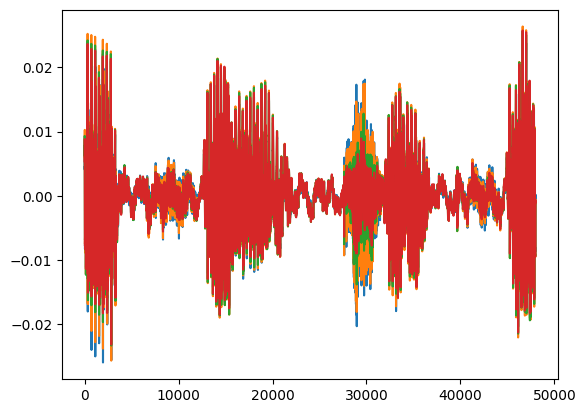

In [33]:
# plt.plot(beam[:,2])

# for channel in range(rec_channels.shape[1]):
#     # print(channel)
#     plt.plot(rec_channels[:480,channel])
plt.plot(rec_channels[:,0])

for beam in range(beams.shape[1]):
    plt.plot(beams[:,beam])

In [25]:
# parameter i/o
import json


param_dict = {0: {'pos': [0., 0., 0.]},
                             1: {'pos': [.04, 0., 0.]},
                             2: {'pos': [.02, -.034641016, 0.]}, 
                             3: {'pos': [-.02, -.034641016, 0.]},
                             4: {'pos': [-.04, 0., 0.]},
                             5: {'pos': [-.02, .034641016, 0.]}, 
                             6: {'pos': [.02, .034641016, 0.]}}

In [26]:

json.dump(param_dict, 'params.json')

AttributeError: 'str' object has no attribute 'write'